## Context
we've explored maximum likelihood methods before of the sort:
$$\hat{a}=[A^TN^{-1}A]^{-1}A^TN^{-1}d
$$
and have found that we don't get fantastic reconstruction unless we use
 - loads of antennas
 - focus only on low-l modes
 - use some kind of missing-modes modelling
 (details are in Imperfect observation strategy in Notion).

The fact that we couldn't reconstruct the monopole well using two antennas with this method made me give up, favouring a method that explicitly uses frequency structure information. Now I'm wondering whether using a large array of antennas we can't get good enough reconstructions of the $l=0$ mode so that a power law + gaussian trough can't be fit over this. It doesn't have to be realistic or good - we could in fact definitely pull a bit of a paper 1 trick and say "lol it's bad but oh well!".


In [1]:
from pygdsm import GlobalSkyModel2016
import healpy as hp
import numpy as np
from numpy.linalg import svd
from scipy.special import eval_legendre
import matplotlib.pyplot as plt
import seaborn as sns

import src.beam_functions as BF
import src.spherical_harmonics as SH
import src.forward_model as FM
import src.sky_models as SM
import src.map_making as MM
import src.plotting as PL

RS = SH.RealSphericalHarmonics()

## Single-frequency reconstruction (for posterity).

In [3]:
# model and observation params
lmax=32
nside=32
npix=hp.nside2npix(nside)
nu=60
narrow_cosbeam = lambda x: BF.beam_cos(x, 0.8)

npix = hp.nside2npix(nside)
# Generate the ylm matrix for later.
ylm_mat = SH.calc_spherical_harmonic_matrix(nside=nside, lmax=lmax)

# Generate foreground map.
fg_alm = SM.foreground_gsma_alm_nsidelo(nu=nu, lmax=lmax, nside=nside, use_mat_Y=True)

calc_spherical_harmonic_matrix npix, nalm : 12288 561


successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561


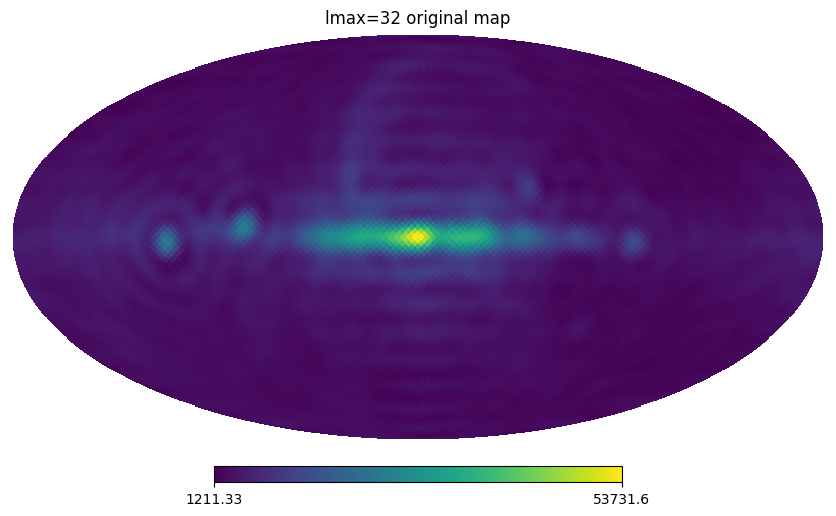

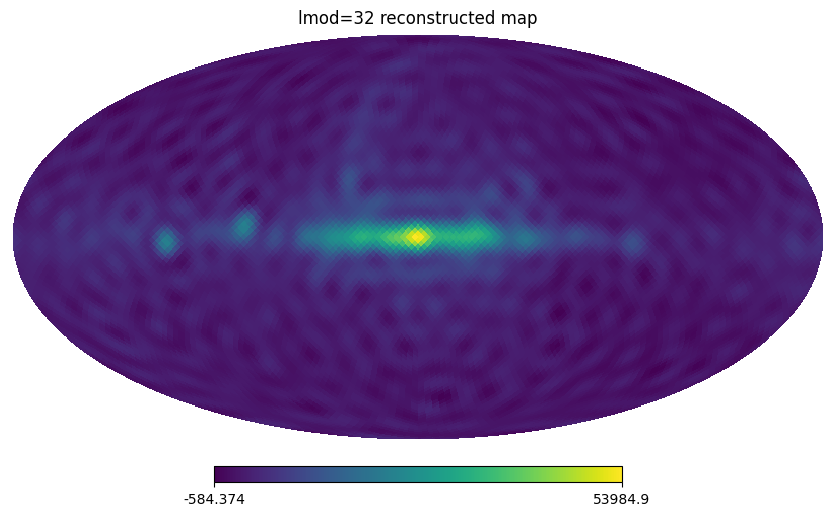

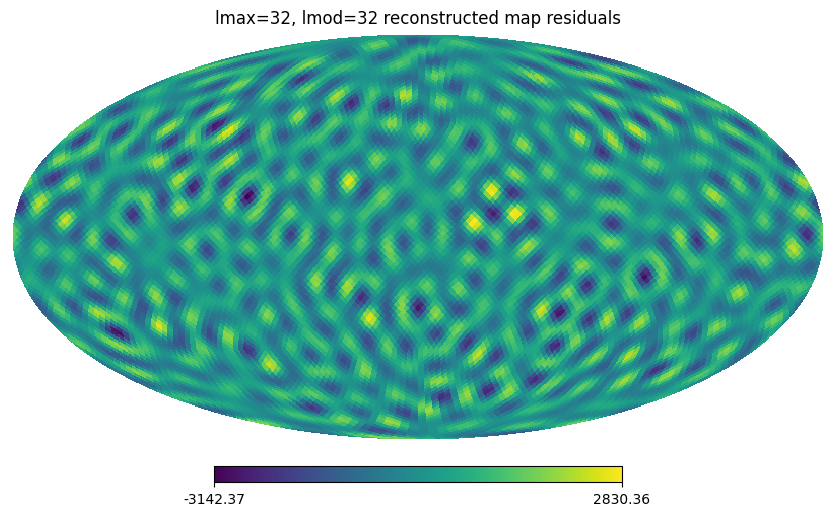

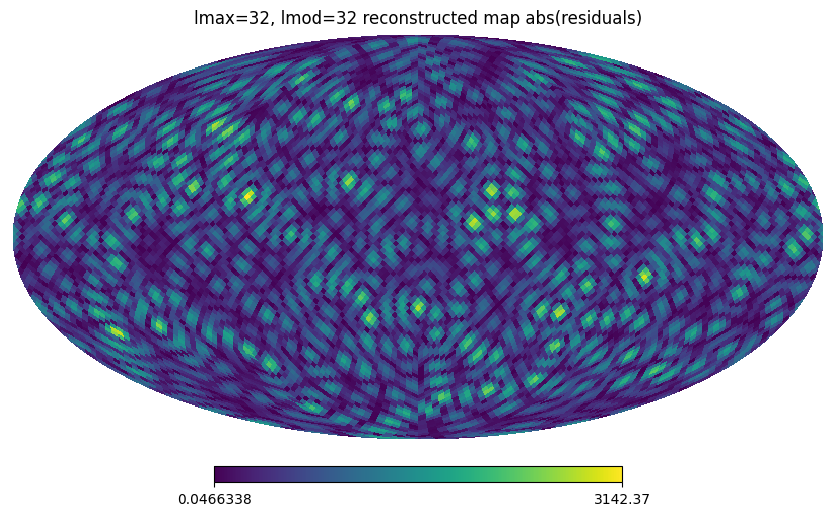

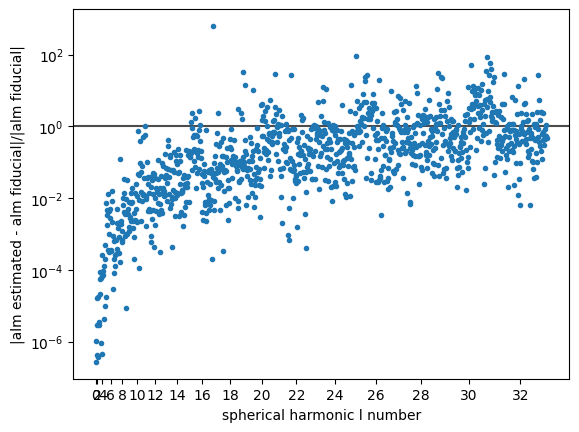

In [4]:
# Observe and reconstruct trivially:
mat_A_triv = FM.calc_observation_matrix_all_pix(nside, lmax, Ntau=npix, beam_use=narrow_cosbeam)

d_triv = mat_A_triv @ fg_alm
dnoisy_triv, noise_covar_triv = SM.add_noise(d_triv, 1, Ntau=npix, t_int=1e4)

mat_W_triv = MM.calc_ml_estimator_matrix(mat_A_triv, noise_covar_triv)
aml_triv = mat_W_triv @ dnoisy_triv

PL.compare_estimate_to_reality(fg_alm, aml_triv, ylm_mat, nside)

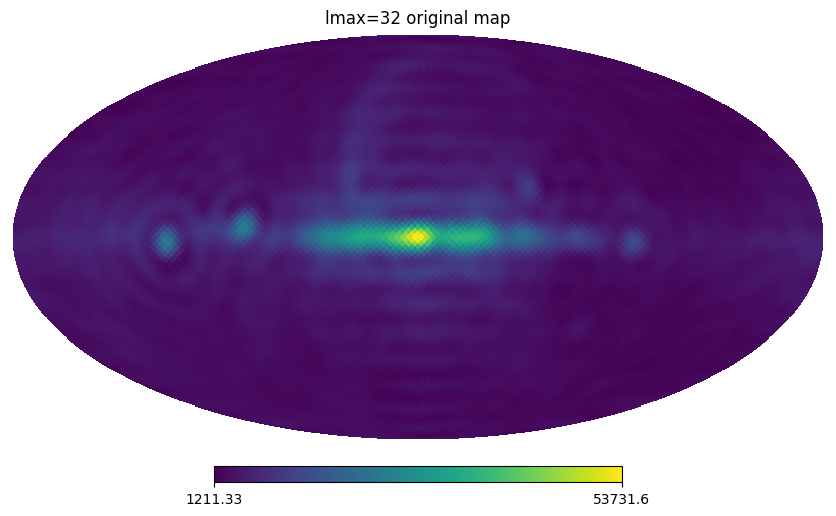

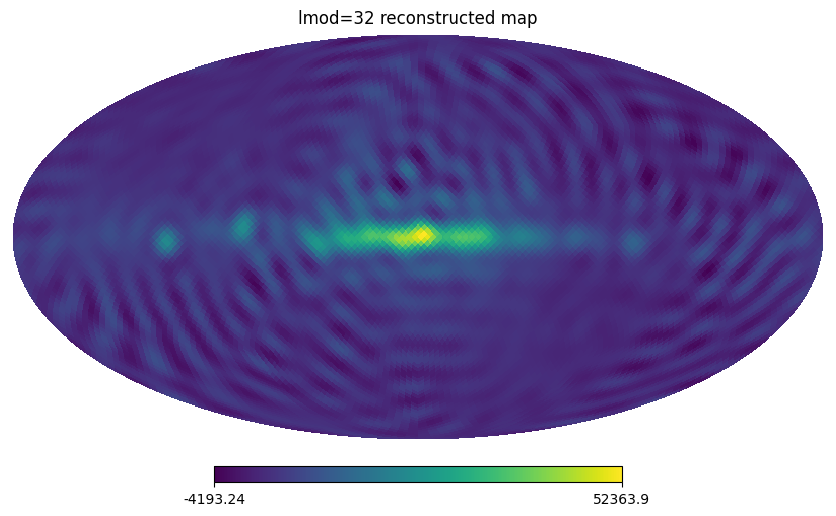

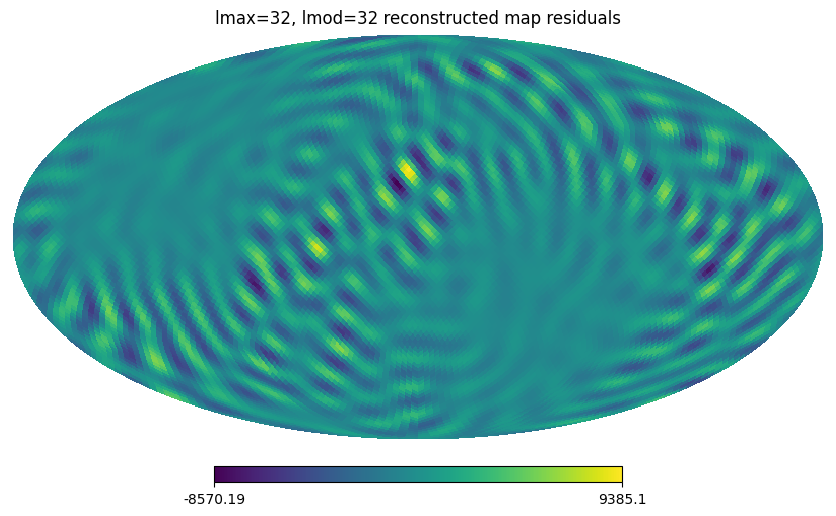

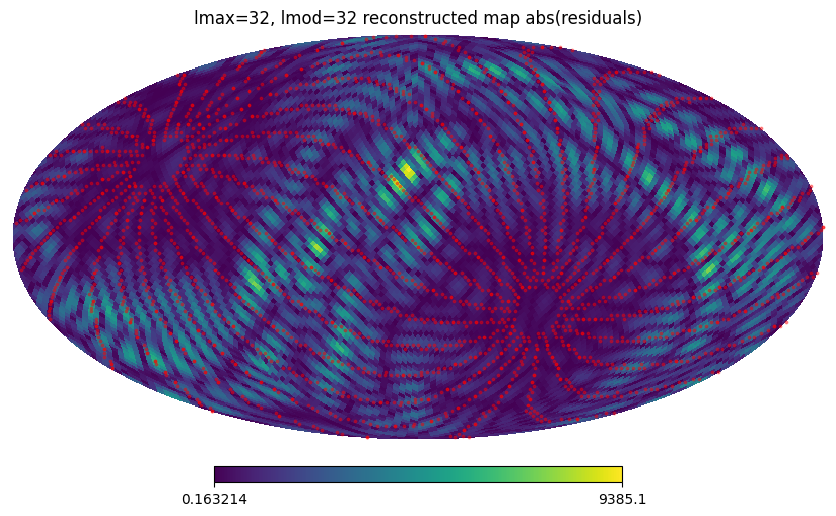

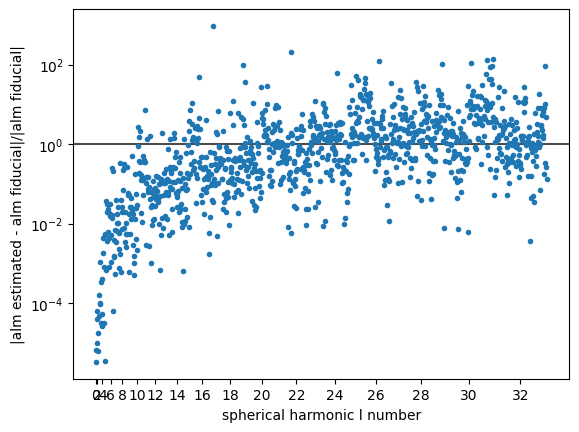

In [5]:
# Observe and reconstruct using a normal observation strategy:
lats = np.linspace(-80, 80, 100)
times = np.linspace(0, 24, 24, endpoint=False)
mat_A_norm, (_, mat_P_norm, _, _) = FM.calc_observation_matrix_multi_zenith_driftscan(nside, lmax, lats=lats, times=times, beam_use=narrow_cosbeam, return_mat=True)

d_norm = mat_A_norm @ fg_alm
dnoisy_norm, noise_covar_norm = SM.add_noise(d_norm, 1, Ntau=len(times), t_int=1e4)

mat_W_norm = MM.calc_ml_estimator_matrix(mat_A_norm, noise_covar_norm)
aml_norm = mat_W_norm @ dnoisy_norm

PL.compare_estimate_to_reality(fg_alm, aml_norm, ylm_mat, nside, mat_P_norm)